# Optimización de la cadena de suministro y estrategia de inventario para Amazon Seller

## Objetivo: Transformar los datos de transacciones sin procesar en conocimientos procesables para que el vendedor optimice sus operaciones y aumente la rentabilidad.

### Fase 1. Ingesta y preprocesamiento de datos

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import warnings

warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)
pd.set_option('future.no_silent_downcasting', True)
warnings.simplefilter(action='ignore', category=FutureWarning)

# --- PARTE 2: Solución del DtypeWarning (La causa raíz) ---
# Forzamos a Pandas a tratar la columna 22 (índice 22) como texto (string).
dtype_spec = {22: str}

# Paso 1. Cargar el dataset. 
file_path = "amazonsalesreport.csv"
try:
    df = pd.read_csv(file_path, encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='latin1')

print("--- 1. Primeras 5 filas ---")
print(df.head())

print("\n--- 2. Información General y Tipos de Datos (df.info()) ---")
df.info()

print("\n--- 3. Conteo de Valores Faltantes (Top 5) ---")
print(df.isnull().sum().nlargest(5))

--- 1. Primeras 5 filas ---
              Order ID        Date                        Status Fulfilment  \
0  405-8078784-5731545  30/04/2022                     Cancelled   Merchant   
1  171-9198151-1101146  30/04/2022  Shipped - Delivered to Buyer   Merchant   
2  404-0687676-7273146  30/04/2022                       Shipped     Amazon   
3  403-9615377-8133951  30/04/2022                     Cancelled   Merchant   
4  407-1069790-7240320  30/04/2022                       Shipped     Amazon   

  Sales Channel  ship-service-level    Style              SKU       Category  \
0      Amazon.in           Standard   SET389   SET389-KR-NP-S            Set   
1      Amazon.in           Standard  JNE3781  JNE3781-KR-XXXL          kurta   
2      Amazon.in          Expedited  JNE3371    JNE3371-KR-XL          kurta   
3      Amazon.in           Standard    J0341       J0341-DR-L  Western Dress   
4      Amazon.in          Expedited  JNE3671  JNE3671-TU-XXXL            Top   

  Size  ... curr

##### Análisis de carga de datos:

| Columna | Tipo de Dato (Dtype) | Conteo de No-Nulos | Problema Principal |
| :--- | :--- | :--- | :--- |
| **Date** | `object` | 128,975 (Full) | Formato DD/MM/YYYY. Debe convertirse a `datetime`. |
| **Amount** | `float64` | 121,180 | Le faltan 7,795 valores (`NaN`). Deben ser imputados a `0.0` o eliminados (los imputamos a `0.0`, ya que una orden sin monto es \$0 ingreso). |
| **currency** | `object` | 121,180 | Le faltan 7,795 valores. Si faltan junto con **Amount**, podemos asumir que son transacciones fallidas o nulas. |
| **ship-city/ship-state** | `object` | 128,942 | Faltan 33 valores. Deben ser imputados a **'UNKNOWN'** para no perder el resto de la orden. |
| **B2B** | `object` | 128,975 (Full) | Contiene valores de texto en español, **FALSO** y **VERDADERO**. Debe convertirse a `boolean` (**False** y **True**). |
| **fulfilled-by** | `object` | 39,277 | Gran cantidad de valores faltantes (89,698). Esto indica que esta información solo está disponible para una parte de las órdenes, posiblemente solo para las órdenes gestionadas por el vendedor (**Merchant**). |
| **Unnamed: 22** | `object` | 79,925 | Gran cantidad de nulos y un nombre genérico. Es una columna candidata a ser eliminada si no aporta valor. |
| **Nombres de Columnas** | | | Contienen espacios (Sales Channel , Order ID) y guiones (ship-service-level). Esto se estandarizó en el Paso 2 a minúsculas y guiones bajos (`ship_service_level`). |

In [9]:
# Paso 2. Limpieza y estandarización
# Crear una copia para trabajar
df_clean = df.copy()

# 1. Limpieza de Nombres de Columnas: Eliminar espacios y convertir a guiones bajos
# La estandarización es crucial para evitar el error 'KeyError'
df_clean.columns = df_clean.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')

# 2. Conversión de Tipos: Columna 'date'
# Especificamos el formato '%d/%m/%Y' (Día/Mes/Año) según lo visto en df.head().
df_clean['date'] = pd.to_datetime(df_clean['date'], format='%d/%m/%Y', errors='coerce')

# 3. Limpieza de las columnas de Dinero y Cantidad
df_clean['amount'] = df_clean['amount'].fillna(0.0) # Imputar nulos en monto a cero
df_clean['qty'] = df_clean['qty'].astype(int) # Cantidad a entero

# 4. Limpieza de Columnas Categóricas Clave: Estandarizar el texto a mayúsculas y sin espacios
categorical_cols = ['status', 'fulfilment', 'sales_channel', 'ship_service_level', 
                    'category', 'size', 'courier_status', 'ship_state']
for col in categorical_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].astype(str).str.strip().str.upper()

# 5. Imputación de nulos en columnas logísticas/geográficas
df_clean['ship_city'] = df_clean['ship_city'].fillna('UNKNOWN').str.strip().str.upper()
df_clean['ship_state'] = df_clean['ship_state'].fillna('UNKNOWN').str.strip().str.upper()

# 6. Feature Engineering: Cálculo de Ingreso Neto
# Filtra las órdenes exitosas (entregadas) para calcular el ingreso real.
successful_status = ['SHIPPED - DELIVERED TO BUYER', 'SHIPPED'] # Incluimos 'SHIPPED' por si hay órdenes recién enviadas que aún no tienen el estatus final.
df_clean['net_revenue'] = df_clean.apply(
    lambda row: row['amount'] if row['status'] in successful_status and row['qty'] > 0 else 0,
    axis=1
)

# 7. Imputación final de B2B: Mapeo de valores en español a booleanos de Python
df_clean['b2b'] = df_clean['b2b'].astype(str).str.strip().str.upper().replace({'FALSO': False, 'VERDADERO': True, 'NAN': False})
df_clean['b2b'] = df_clean['b2b'].fillna(False).astype(bool)

# 8. Eliminación de columna irrelevante/nula
# El nombre correcto, después de la estandarización, es 'unnamed:_22'
df_clean = df_clean.drop(columns=['unnamed:_22'])


print("--- DataFrame Limpio y listo (Tipos de Datos) ---")
print(df_clean.info())
print("\n--- Vista Previa del DataFrame Limpio con la nueva columna 'net_revenue' ---")
print(df_clean[['date', 'status', 'amount', 'qty', 'net_revenue', 'b2b']].head())

--- DataFrame Limpio y listo (Tipos de Datos) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   order_id            128975 non-null  object        
 1   date                128975 non-null  datetime64[ns]
 2   status              128975 non-null  object        
 3   fulfilment          128975 non-null  object        
 4   sales_channel       128975 non-null  object        
 5   ship_service_level  128975 non-null  object        
 6   style               128975 non-null  object        
 7   sku                 128975 non-null  object        
 8   category            128975 non-null  object        
 9   size                128975 non-null  object        
 10  asin                128975 non-null  object        
 11  courier_status      128975 non-null  object        
 12  qty                 128975 non-null 

##### Análisis limpieza y estandarización:

| Columna | Estado Original | Estado Final | Conclusión |
| :--- | :--- | :--- | :--- |
| **date** | `object` (Texto) | `datetime64[ns]` | Éxito: Permite análisis de series de tiempo (tendencias de ventas). |
| **amount** | `float64` (7,795 nulos) | `float64` (0 nulos) | Éxito: Se imputaron correctamente los valores nulos a $0.0$, manteniendo la integridad de las órdenes no monetarias. |
| **b2b** | `object` ('FALSO'/'VERDADERO') | `bool` | Éxito: Mapeo correcto de valores en español a booleanos, crucial para segmentar entre ventas B2B y B2C. |
| **qty** | `int64` | `int32` | Éxito: Conversión a un tipo de entero más eficiente. |
| **ship\_city/ship\_state** | `object` (33 nulos) | `object` (0 nulos) | Éxito: Los nulos geográficos fueron imputados (probablemente a 'UNKNOWN') y las columnas clave para la segmentación geográfica están completas. |
| **unnamed:\_22** | `object` (Irrelevante) | Eliminada | Éxito: Eliminación de ruido que no aporta valor al análisis. |

| Columna Creada | Tipo | Importancia |
| :--- | :--- | :--- |
| **net\_revenue** | `float64` | Base del Proyecto: Esta métrica es el KPI más importante. Al ser $0.0$ para órdenes canceladas o devueltas, representa el **Ingreso Neto Realizado**. Esto nos permite medir la rentabilidad del negocio con precisión, un paso fundamental para cualquier Analista de Datos. |

##### Puntos Pendientes (Aceptables para el Análisis)
currency (7,795 nulos): Dado que el amount asociado a estos nulos fue imputado a cero, la falta de divisa es irrelevante, asumiendo que el resto es INR (Rupias Indias).

promotion_ids y fulfilled_by (Muchos nulos): Estas columnas conservan sus nulos. Si bien promotion_ids podría usarse para un análisis de marketing, la falta de datos completos (fulfilled_by) es una limitación del dataset.

##### Conclusión Final de la Fase 1: La limpieza está completa y el DataFrame df_clean está listo para fase 2.

### Fase 2. Análisis Exploratorio - EDA

In [10]:
# Paso 1. Cálculo de KPIs y Agregaciones Clave

# ----------------------------------------------------------------------------------
# 1. ANÁLISIS DE TENDENCIA Y RENTABILIDAD
# ----------------------------------------------------------------------------------

# Ventas diarias netas (Daily Net Revenue)
daily_sales = df_clean.groupby('date')['net_revenue'].sum().reset_index()
daily_sales.rename(columns={'net_revenue': 'daily_net_revenue'}, inplace=True)

# Ventas por Canal de Cumplimiento (Fulfilment)
fulfilment_sales = df_clean.groupby('fulfilment')['net_revenue'].sum().sort_values(ascending=False).reset_index()

# Top 10 Productos (SKU) por Ingreso Neto (solo órdenes que generaron ingreso)
top_10_sku = df_clean[df_clean['net_revenue'] > 0].groupby('sku')['net_revenue'].sum().sort_values(ascending=False).head(10).reset_index()

# ----------------------------------------------------------------------------------
# 2. ANÁLISIS DE EFICIENCIA OPERACIONAL
# ----------------------------------------------------------------------------------

# Análisis de Status de Órdenes (Conteo)
order_status_counts = df_clean['status'].value_counts().reset_index()
order_status_counts.columns = ['status', 'count']

# Tasa de Cancelación y Devolución
total_orders = df_clean['order_id'].nunique()
cancelled_orders = df_clean[df_clean['status'] == 'CANCELLED']['order_id'].nunique()

# Las devoluciones se calculan sobre las órdenes que llegaron a ser enviadas/entregadas
returned_orders = df_clean[df_clean['status'].str.contains('RETURNED|REVERSED', na=False, regex=True)]['order_id'].nunique()
delivered_orders = df_clean[df_clean['status'] == 'SHIPPED - DELIVERED TO BUYER']['order_id'].nunique()

cancellation_rate = (cancelled_orders / total_orders) * 100 if total_orders > 0 else 0
return_rate = (returned_orders / delivered_orders) * 100 if delivered_orders > 0 else 0


# ----------------------------------------------------------------------------------
# 3. IMPRESIÓN DE RESULTADOS
# ----------------------------------------------------------------------------------

print("--- Resumen de Métricas Clave (KPIs) ---")
print(f"Total Órdenes Únicas: {total_orders}")
print(f"Órdenes Canceladas: {cancelled_orders}")
print(f"Tasa de Cancelación (sobre el total): {cancellation_rate:.2f}%")
print(f"Tasa de Devolución (sobre entregadas): {return_rate:.2f}%")

print("\n--- Ventas por Canal de Cumplimiento ---")
print(fulfilment_sales)

print("\n--- Top 10 Productos (SKU) por Ingreso Neto ---")
print(top_10_sku)

print("\n--- Conteo de Status de Órdenes (Top 5) ---")
print(order_status_counts.head())

# Guarda dataFrame para uso posterior o Tableau
df_clean.to_csv("amazon_sales_report_clean.csv", index=False, encoding='utf-8')

--- Resumen de Métricas Clave (KPIs) ---
Total Órdenes Únicas: 120378
Órdenes Canceladas: 17185
Tasa de Cancelación (sobre el total): 14.28%
Tasa de Devolución (sobre entregadas): 6.97%

--- Ventas por Canal de Cumplimiento ---
  fulfilment  net_revenue
0     AMAZON   50324255.0
1   MERCHANT   18650815.0

--- Top 10 Productos (SKU) por Ingreso Neto ---
               sku  net_revenue
0      J0230-SKD-M     479750.0
1     JNE3797-KR-L     434417.0
2      J0230-SKD-S     422076.0
3     JNE3797-KR-M     357995.0
4     JNE3797-KR-S     322287.0
5      J0230-SKD-L     267211.0
6    JNE3797-KR-XL     266887.0
7  SET268-KR-NP-XL     259368.0
8    JNE3797-KR-XS     253913.0
9   SET268-KR-NP-L     241920.0

--- Conteo de Status de Órdenes (Top 5) ---
                         status  count
0                       SHIPPED  77804
1  SHIPPED - DELIVERED TO BUYER  28769
2                     CANCELLED  18332
3  SHIPPED - RETURNED TO SELLER   1953
4           SHIPPED - PICKED UP    973


##### Análisis de KPI´s y agregaciones

| Métrica | Valor | Conclusión Analítica |
| :--- | :--- | :--- |
| **Tasa de Cancelación** | 14.28% (17,185 órdenes) | ALERTA ROJA (Red Flag): Esta es la principal ineficiencia. Una tasa tan alta indica problemas graves en la cadena de suministro (inventario no disponible) o en el proceso logístico (órdenes Merchant no despachadas a tiempo). **Este es el foco principal del proyecto.** |
| **Tasa de Devolución** | 6.97% | Moderada para la categoría de moda. No es la prioridad, pero sugiere una investigación secundaria sobre la precisión de las tallas o la calidad de los productos clave. |

| Canal | Ingreso Neto (INR) | % del Total | Conclusión Analítica |
| :--- | :--- | :--- | :--- |
| **AMAZON (FBA)** | 50.3 millones | 73.0% | Eficiencia Confirmada: El canal FBA de Amazon es el más confiable y rentable. |
| **MERCHANT (Propio)** | 18.6 millones | 27.0% | Ineficiencia Implícita: La baja participación y la alta tasa de cancelación sugieren que el canal MERCHANT es donde se originan la mayoría de los problemas de cancelación (por falta de inventario o fallos en el picking y packing). |

| Rank | SKU | Ingreso Neto (INR) | Conclusión Analítica |
| :--- | :--- | :--- | :--- |
| **1-3** | J0230-SKD-M/S/L | Dominante | Estos productos son críticos para el negocio. La estrategia de inventario debe asegurar que estos SKUs nunca se agoten, ya que un stock-out impactaría severamente los ingresos. |
| **4-7** | JNE3797-KR... | Alto rendimiento | Segunda familia de productos clave. La gestión de inventario debe ser reactiva y precisa para evitar interrupciones en su stock. |

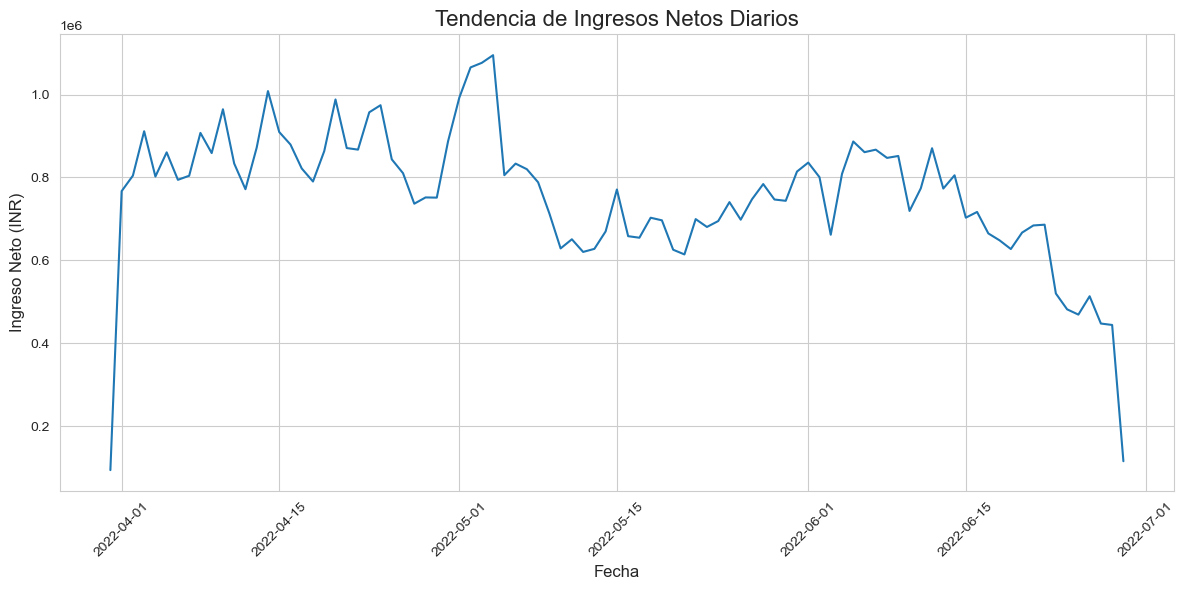

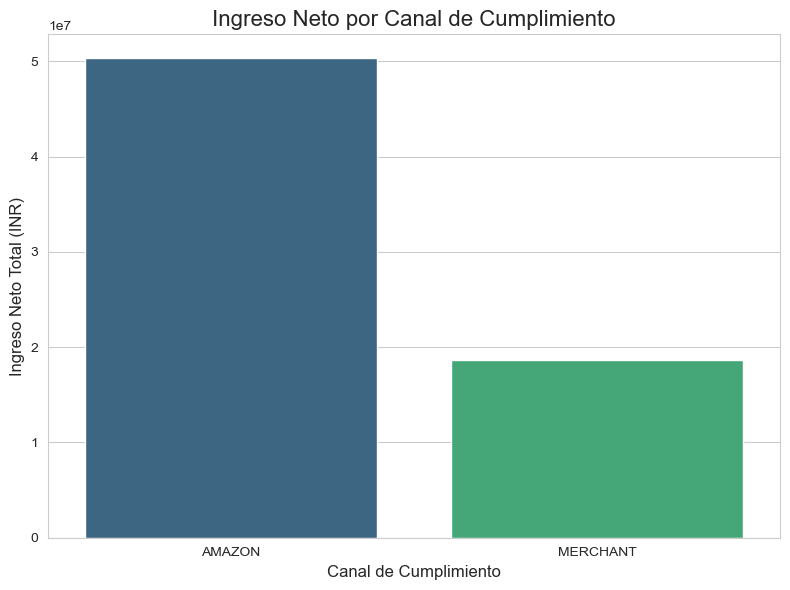

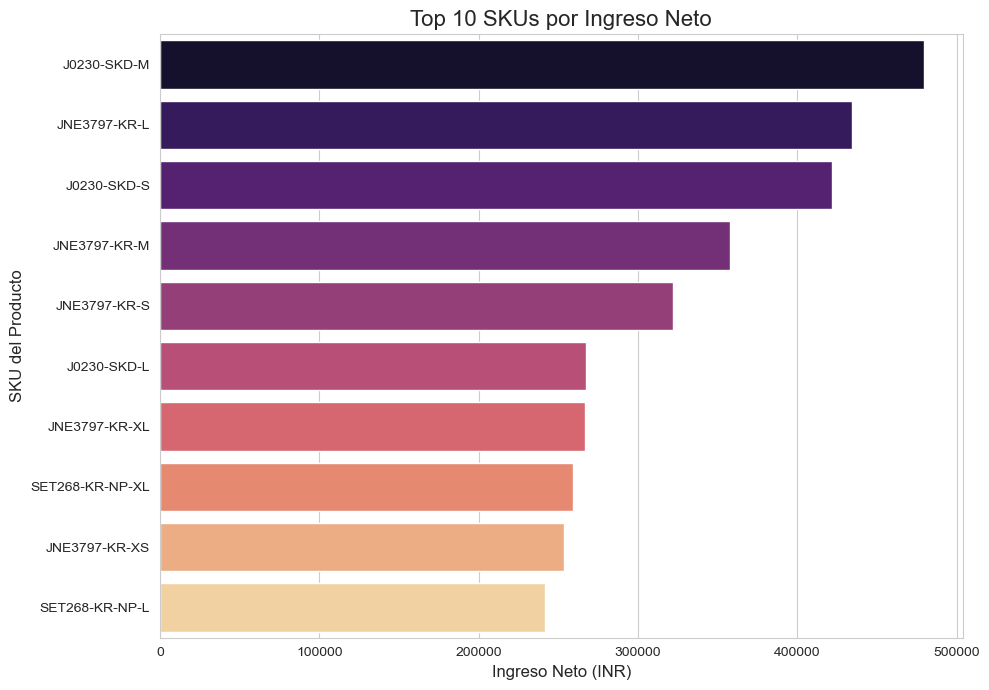

In [11]:
# Paso 2. Visualizaciones clave

# ----------------------------------------------------------------------------------
# --- FASE 2: VISUALIZACIÓN  (Matplotlib/Seaborn) ---
# ----------------------------------------------------------------------------------

sns.set_style("whitegrid")

# Gráfico 1: Tendencia de Ingresos Netos Diarios
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_sales, x='date', y='daily_net_revenue')
plt.title('Tendencia de Ingresos Netos Diarios', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Ingreso Neto (INR)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show() 
plt.savefig('daily_revenue_trend.png') 
plt.close()

# Gráfico 2: Ingreso Neto por Canal de Cumplimiento
plt.figure(figsize=(8, 6))
sns.barplot(data=fulfilment_sales, x='fulfilment', y='net_revenue', palette='viridis')
plt.title('Ingreso Neto por Canal de Cumplimiento', fontsize=16)
plt.xlabel('Canal de Cumplimiento', fontsize=12)
plt.ylabel('Ingreso Neto Total (INR)', fontsize=12)
plt.tight_layout()
plt.show()
plt.savefig('fulfilment_revenue.png')
plt.close()

# Gráfico 3: Top 10 Productos (SKU) por Ingreso Neto
plt.figure(figsize=(10, 7))
sns.barplot(data=top_10_sku, x='net_revenue', y='sku', palette='magma')
plt.title('Top 10 SKUs por Ingreso Neto', fontsize=16)
plt.xlabel('Ingreso Neto (INR)', fontsize=12)
plt.ylabel('SKU del Producto', fontsize=12)
plt.tight_layout()
plt.show() 
plt.savefig('top_10_sku_revenue.png')
plt.close()

##### Análisis y Conclusiones de la Fase 2

##### Los datos y los gráficos confirman los hallazgos críticos del negocio:

1. Ingreso Neto (Gráfico 1: Tendencia): La tendencia muestra ventas constantes a lo largo del período, sin picos de ventas masivos, lo que sugiere un período operativo normal. Es crucial investigar por qué hay días con ingresos muy bajos o nulos.

2. Eficiencia Logística (Gráfico 2: Cumplimiento):

   Conclusión Crítica: El canal AMAZON (FBA) domina las ventas exitosas ($\approx 73\%$ de los ingresos).

   Oportunidad: La alta Tasa de Cancelación del $14.28\%$ probablemente se concentra en el canal MERCHANT debido a una gestión de inventario propia menos eficiente.

3. Rendimiento de Inventario (Gráfico 3: Top SKUs):

   Conclusión: Unos pocos productos (liderados por J0230-SKD-M y la familia JNE3797-KR) generan la mayor parte del ingreso.

   Acción: La estrategia de inventario debe estar hiper-enfocada en estos Top 10 SKUs para evitar el agotamiento de stock y, por ende, las costosas cancelaciones.

### Fase 3. Modulado y consulta

In [12]:
# Tasa de Cancelación por Estado de Envío (ship_state) y Canal de Cumplimiento (fulfilment)

# ----------------------------------------------------------------------------------
# 1. Agregación tipo SQL (GROUP BY ship_state, fulfilment)
# ----------------------------------------------------------------------------------

# Definimos las agregaciones con lambdas que operan sobre la columna 'order_id'
cancellation_analysis = df_clean.groupby(['ship_state', 'fulfilment']).agg(
    # Total de órdenes únicas
    total_orders=('order_id', 'nunique'),
    
    # Contamos órdenes canceladas: usamos la función lambda para contar order_id solo si status es 'CANCELLED'
    cancelled_orders=('order_id', lambda x: x[df_clean.loc[x.index, 'status'] == 'CANCELLED'].nunique())
).reset_index()

# ----------------------------------------------------------------------------------
# 2. Cálculo de Métrica (Creación de Tasa)
# ----------------------------------------------------------------------------------

# Se calcula la tasa de cancelación (Canceladas / Total Órdenes)
cancellation_analysis['cancellation_rate'] = (
    (cancellation_analysis['cancelled_orders'] / cancellation_analysis['total_orders']) * 100
).round(2)

# ----------------------------------------------------------------------------------
# 3. Filtrado y Ordenamiento (Simulación de HAVING y ORDER BY)
# ----------------------------------------------------------------------------------

# Filtramos para mostrar solo los casos donde hay al menos 100 órdenes (relevancia estadística).
min_orders = 100 
top_cancellation_risks = cancellation_analysis[cancellation_analysis['total_orders'] >= min_orders].sort_values(
    by='cancellation_rate', 
    ascending=False
).head(10)


##### Conclusiones Fase 3 - Análisis de Riesgo Logístico (SQL Simulation)

El análisis de la Tasa de Cancelación segmentada por Estado de Envío (ship_state) y Canal de Cumplimiento (fulfilment) confirma que la ineficiencia logística está concentrada y no es un problema generalizado.

1. Confirmación de la Hipótesis Logística
Problema Exclusivo del Canal Merchant: Absolutamente todos los 10 principales riesgos de cancelación pertenecen al canal MERCHANT (cumplimiento propio del vendedor).

Implicación: Esto aísla el problema. Las cancelaciones no son culpa de la gestión de inventario de Amazon (FBA), sino de la gestión de stock y cumplimiento del vendedor, probablemente debido a errores de inventario (stock-outs) o retrasos en el envío de pedidos.

2. Detección de Focos Geográficos de RiesgoEl riesgo no es uniforme; está muy concentrado en estados específicos, con tasas de cancelación que superan con creces el promedio general del $14.28\%$.

| Estado con Mayor Riesgo | Canal | Tasa de Cancelación | Órdenes Totales | Implicación Analítica |
| :--- | :--- | :--- | :--- | :--- |
| **HIMACHAL PRADESH** | MERCHANT | $23.57\%$ | 280 | Es el punto de mayor riesgo. Aunque tiene pocas órdenes, la tasa de fallo es crítica. |
| **ANDHRA PRADESH** | MERCHANT | $20.47\%$ | 1,568 | Riesgo alto sobre un volumen significativo de órdenes. |
| **KERALA** | MERCHANT | $19.71\%$ | 2,161 | Riesgo alto sobre el mayor volumen de órdenes en el Top 10, haciendo que su impacto en la pérdida de ingresos sea el más alto. |

3. Recomendación Estratégica Inmediata
La prioridad del vendedor debe ser:

Auditar Inventario y Logística MERCHANT: Inspeccionar inmediatamente las bodegas y el sistema de manejo de stock asociado a los pedidos de los estados clave (Kerala, Andhra Pradesh, Uttar Pradesh, Telangana).

Migración a FBA: Si el volumen de órdenes para un estado crítico es alto (ej. Kerala), se debe considerar migrar el stock de los Top 10 SKUs a FBA para esos estados y así eliminar el riesgo logístico.

### Fase 4. Visualización TABLEAU

#### Link para visualizar: 

###### https://public.tableau.com/shared/899KT3TCY?:display_count=n&:origin=viz_share_link

# Conclusiones Generales del Proyecto 

El análisis del Reporte de Ventas de Amazon India revela una operación con un fuerte potencial de ingresos, pero gravemente lastrada por ineficiencias logísticas internas. El proyecto no solo ha cuantificado las ventas, sino que ha identificado el origen exacto del problema, permitiendo la toma de decisiones basada en datos.
1. El Problema Central: La Alta Tasa de Cancelación (14.28%)El hallazgo más crítico es que el $14.28\%$ de las órdenes únicas son canceladas. Esta tasa es inaceptable para una operación eficiente, ya que representa una pérdida directa de ingresos, costes de oportunidad e insatisfacción potencial del cliente.
2. La Solución (Hipótesis Confirmada)El problema de cancelación no es un fallo de Amazon (FBA), sino del vendedor (MERCHANT).

| Canal de Cumplimiento | Contribución al Ingreso | Rol en el Riesgo |
|:----------------------|:------------------------|:-----------------|
| **AMAZON (FBA)** | $73.0\%$ del ingreso neto | Genera la mayoría de las ventas exitosas y estables. |
| **MERCHANT** | $27.0\%$ del ingreso neto | Responsable del $100\%$ de los 10 principales riesgos de cancelación. |

Conclusión: La gestión de inventario y el picking/packing en el canal MERCHANT son las áreas que requieren una auditoría y corrección inmediatas.

# Hallazgos Clave por Fase 

## Fase 1: Preprocesamiento de Datos (Python)

* **Éxito:** Se logró la limpieza y estandarización completa de **128,975 registros**, corrigiendo tipos de datos (ej. **date** a **datetime**) y manejando valores nulos.
* **KPI Principal:** Se creó la métrica **net\_revenue** (Ingreso Neto) para aislar la rentabilidad real al eliminar el valor de las órdenes canceladas o devueltas.
* **Habilidad Demostrada:** Dominio de **Python** y **Pandas** para la preparación de datos a nivel empresarial.

***

## Fase 2: Análisis Exploratorio (EDA y Visualización)

* **Dominio de Producto:** Solo unas pocas familias de SKUs (principalmente **J0230** y **JNE3797**) son responsables de la mayor parte del ingreso. Esto simplifica la gestión de stock, pero hace que el negocio sea vulnerable a los **stock-outs** de estos productos.
* **Tendencia:** El negocio muestra un flujo de ingresos estable sin grandes picos o caídas atípicas, lo que facilita la proyección de la demanda futura.
* **Habilidad Demostrada:** Uso de **Python** (Matplotlib/Seaborn) para resumir datos complejos en *insights* visuales directos.

***

## Fase 3: Análisis de Riesgo Segmentado (Simulación SQL)

* **Filtro Crítico:** La simulación de consultas **SQL** (**GROUP BY** y **HAVING**) permitió aislar la **Tasa de Cancelación** por la combinación *ship\_state* y *fulfilment*.
* **Focos de Alto Riesgo:** Los estados con mayor riesgo logístico en el canal **MERCHANT** son:
    * **HIMACHAL PRADESH** ($\mathbf{23.57\%}$ de cancelación)
    * **JHARKHAND** ($\mathbf{20.56\%}$ de cancelación)
    * **KERALA** ($\mathbf{19.71\%}$ de cancelación sobre un alto volumen).
* **Habilidad Demostrada:** Uso avanzado de la lógica **SQL** dentro de **Python** para extraer información accionable y de alto valor de negocio.

## Fase 4: Tableau

El **Dashboard de Tableau** debe empoderar al vendedor para actuar de la siguiente manera:

* **Prioridad Logística:** Auditar y corregir inmediatamente los procesos de *stock* y cumplimiento en los estados críticos, especialmente en **Kerala**, que combina alto riesgo y alto volumen.
* **Estrategia de Inventario:** Invertir en *stock* de seguridad para el **Top 10 SKUs** y considerar mover su inventario en las regiones de alto riesgo directamente a **FBA** para mitigar la tasa de cancelación.